In [1]:
#imorting dependencies
import numpy as np
import sympy as sp


In [2]:
class variables:
    def __init__(self):
        self.gen_variables()
        self.gen_H()
        self.H_scaled = self.normalize(self.H_A)
        
    def gen_variables(self):   
        self.E_c    = sp.Symbol("E_c")
        self.E_b    = sp.Symbol("E_b")
        self.E_a    = sp.Symbol("E_a")

        self.h      = sp.Symbol("h")
        self.Om_cb  = sp.Symbol("\Omega_{cb}")
        self.Om_ba  = sp.Symbol("\Omega_{ba}")
        self.V_cb   = self.h*self.Om_cb/2
        self.V_ba   = self.h*self.Om_ba/2
        self.om_cb  = sp.Symbol("\omega_{L'}")
        self.om_ba  = sp.Symbol("\omega_{L}")
        self.I      = sp.Symbol("I")
        self.t      = sp.Symbol("t")
        self.e_cb_lower   = sp.exp(self.I*self.om_cb*self.t)
        self.e_cb_upper   = sp.exp(-self.I*self.om_cb*self.t)
        self.e_ba_lower   = sp.exp(self.I*self.om_ba*self.t)
        self.e_ba_upper   = sp.exp(-self.I*self.om_ba*self.t)

        self.values = [(self.E_c,5),(self.E_b,4),(self.E_a,1),(self.h,1),(self.Om_cb,0.05),(self.Om_ba,0.2),(self.om_cb,1.1),(self.om_ba,3),(self.I,1j)]
        
    def gen_H(self):
        self.H_A =sp.Matrix([
            [self.E_c,0,0],
            [0,self.E_b,0],
            [0,0,self.E_a]
        ])

        self.V_1 =self.V_cb*sp.Matrix([
            [0,              self.e_cb_upper,0],
            [self.e_cb_lower,0              ,0],
            [0,              0              ,0]
        ])
        self.V_2 =self.V_ba*sp.Matrix([
            [0, 0,                      0],
            [0,0         ,self.e_ba_upper],
            [0,self.e_ba_lower         ,0]
        ])

        self.H = self.H_A + self.V_1 + self.V_2
    def Trace(self,H):
        s=0
        for i in range(H.shape[0]):
            s+=H[i,i]
        return s
    def normalize(self,H): #normalizing some input hamiltonian
        a=self.Trace(H*H)
        scale = sp.sqrt(a/2)
        H_scaled = H/scale
        return H_scaled

In [3]:
var = variables()

H_scaled = var.H_scaled.subs(var.values)
H_scaled

Matrix([
[5*sqrt(21)/21,             0,           0],
[            0, 4*sqrt(21)/21,           0],
[            0,             0, sqrt(21)/21]])

In [4]:
from sympy.physics.quantum.dagger import Dagger
class SU_3:
    def __init__(self,H):
        self.H   = H 
        self.H_det = sp.det(self.H)
        self.phi = self.det_to_phi()
        self.t   = sp.Symbol("t")
        
    
    def det_to_phi(self):
        phi  = sp.Symbol("\phi")
        res  = sp.solvers.solve((2/(3*sp.sqrt(3)))*sp.sin(phi)+self.H_det,phi)
        return min(res)
    def term_k(self,k):
        out_bra_u = (sp.exp((2/sp.sqrt(3))*1j*self.t*(sp.sin(self.phi+(2*sp.pi*k)/3)))).evalf()
        out_bra_l = (1 - 2*sp.cos(2*(self.phi+(2*sp.pi*k)/3))).evalf()
        out_bra   = out_bra_u/out_bra_l
        first = self.H*self.H
        second= (2/sp.sqrt(3))*self.H*(sp.sin(self.phi+(2*sp.pi*k)/3)).evalf()
        third = -(1/3)*sp.eye((self.H).shape[0])*(1+2*sp.cos(2*(self.phi+(2*sp.pi*k)/3))).evalf()
        return (first+second+third)*out_bra
    def gen_unitary_m(self):
        U = sp.Matrix(np.zeros((3,3)))
        for k in range(3): 
            U+=self.term_k(k)
        return U





In [14]:
inst = SU_3(H_scaled)
U = sp.simplify(inst.gen_unitary_m())
U_dagg = Dagger(U)
H_scaled

Matrix([
[5*sqrt(21)/21,             0,           0],
[            0, 4*sqrt(21)/21,           0],
[            0,             0, sqrt(21)/21]])

In [6]:
from sympy.utilities.lambdify import lambdify
rho = sp.Matrix([
    [0,1,0],
    [1,0,0],
    [0,0,0]
])
rho_evol = U*rho*U_dagg
rho_evol_f = lambdify(inst.t,rho_evol)

t=np.linspace(0,10,100)
RHO_EVOL = rho_evol_f(t)
np.real(RHO_EVOL[1][0][1])


0.9997463795155077

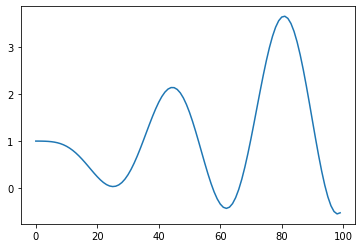

In [13]:
class m_vectors:
    def __init__(self,RHO_EVOL,t):
        self.t = t
        self.RHO_EVOL = RHO_EVOL
        self.gen_rho_el()
        self.lengthen_arrays(self.rho_l)
        self.m_l = self.gen_m()
    def gen_rho_el(self):
        self.rho_l  = [
            self.RHO_EVOL[0][0],
            self.RHO_EVOL[0][1],
            self.RHO_EVOL[0][2],
            self.RHO_EVOL[1][0],
            self.RHO_EVOL[1][1],
            self.RHO_EVOL[1][2],
            self.RHO_EVOL[2][0],
            self.RHO_EVOL[2][1],
            self.RHO_EVOL[2][2],
        ]
       
    def lengthen_arrays(self,arr):
        self.rho_l_len=[]
        for l in arr:
            try:
                len(l)
                self.rho_l_len.append(l)
            except TypeError:
                self.rho_l_len.append(np.zeros(len(t))+l)
    def gen_m(self):
        arr = []
        arr.append(np.sqrt(3)*np.real(self.rho_l_len[1]))
        arr.append(np.sqrt(3)*np.imag(self.rho_l_len[1]))
        return arr

m_inst = m_vectors(RHO_EVOL,t)

test = m_inst.m_l
test = m_inst.rho_l[1]

import matplotlib.pyplot as plt

plt.plot(np.real(test))
plt.show()